In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import FeatureUnion
from sklearn.metrics import f1_score,\
                            roc_auc_score,\
                            precision_score,\
                            classification_report,\
                            precision_recall_curve,\
                            confusion_matrix

In [3]:
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [4]:
import itertools
import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [6]:
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis= 1 , inplace= True )

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [8]:
df.head(3)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [9]:
X = df[df.columns[0:10]]
y = df['Exited']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,
                                                    random_state=16)

In [11]:
categorical_columns = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'Tenure', 'NumOfProducts', 'EstimatedSalary']

In [12]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [13]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col))
            ])
    final_transformers.append((cont_col, cont_transformer))

In [14]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [15]:
# CatBoostClassifier()
# LGBMClassifier()
pipeline = Pipeline([
    ('features',feats),
    ('classifier', CatBoostClassifier())
])

In [16]:
pipeline.fit(X_train, y_train)

Learning rate set to 0.02321
0:	learn: 0.6747443	total: 137ms	remaining: 2m 16s
1:	learn: 0.6590828	total: 143ms	remaining: 1m 11s
2:	learn: 0.6428202	total: 149ms	remaining: 49.4s
3:	learn: 0.6269188	total: 154ms	remaining: 38.5s
4:	learn: 0.6115016	total: 161ms	remaining: 31.9s
5:	learn: 0.5973210	total: 167ms	remaining: 27.6s
6:	learn: 0.5839371	total: 173ms	remaining: 24.5s
7:	learn: 0.5717285	total: 179ms	remaining: 22.1s
8:	learn: 0.5596007	total: 185ms	remaining: 20.3s
9:	learn: 0.5486297	total: 191ms	remaining: 19s
10:	learn: 0.5379459	total: 198ms	remaining: 17.8s
11:	learn: 0.5290548	total: 204ms	remaining: 16.8s
12:	learn: 0.5209894	total: 210ms	remaining: 15.9s
13:	learn: 0.5141797	total: 215ms	remaining: 15.1s
14:	learn: 0.5056867	total: 221ms	remaining: 14.5s
15:	learn: 0.4969379	total: 226ms	remaining: 13.9s
16:	learn: 0.4888640	total: 232ms	remaining: 13.4s
17:	learn: 0.4814475	total: 238ms	remaining: 13s
18:	learn: 0.4746088	total: 244ms	remaining: 12.6s
19:	learn: 0.4

173:	learn: 0.3182794	total: 1.1s	remaining: 5.21s
174:	learn: 0.3180543	total: 1.1s	remaining: 5.2s
175:	learn: 0.3178751	total: 1.11s	remaining: 5.19s
176:	learn: 0.3177085	total: 1.11s	remaining: 5.18s
177:	learn: 0.3175156	total: 1.12s	remaining: 5.17s
178:	learn: 0.3171629	total: 1.13s	remaining: 5.16s
179:	learn: 0.3169850	total: 1.13s	remaining: 5.15s
180:	learn: 0.3168170	total: 1.14s	remaining: 5.14s
181:	learn: 0.3166817	total: 1.14s	remaining: 5.13s
182:	learn: 0.3164218	total: 1.15s	remaining: 5.12s
183:	learn: 0.3162890	total: 1.15s	remaining: 5.12s
184:	learn: 0.3161463	total: 1.16s	remaining: 5.11s
185:	learn: 0.3159307	total: 1.16s	remaining: 5.1s
186:	learn: 0.3157956	total: 1.17s	remaining: 5.09s
187:	learn: 0.3156122	total: 1.18s	remaining: 5.08s
188:	learn: 0.3154759	total: 1.18s	remaining: 5.07s
189:	learn: 0.3153138	total: 1.19s	remaining: 5.06s
190:	learn: 0.3151095	total: 1.19s	remaining: 5.05s
191:	learn: 0.3150487	total: 1.2s	remaining: 5.03s
192:	learn: 0.314

339:	learn: 0.2947109	total: 2s	remaining: 3.89s
340:	learn: 0.2946076	total: 2.01s	remaining: 3.88s
341:	learn: 0.2944293	total: 2.01s	remaining: 3.87s
342:	learn: 0.2943305	total: 2.02s	remaining: 3.87s
343:	learn: 0.2941910	total: 2.02s	remaining: 3.86s
344:	learn: 0.2940922	total: 2.03s	remaining: 3.85s
345:	learn: 0.2939486	total: 2.04s	remaining: 3.85s
346:	learn: 0.2937508	total: 2.04s	remaining: 3.84s
347:	learn: 0.2935645	total: 2.05s	remaining: 3.83s
348:	learn: 0.2934608	total: 2.05s	remaining: 3.83s
349:	learn: 0.2933351	total: 2.06s	remaining: 3.82s
350:	learn: 0.2932039	total: 2.06s	remaining: 3.81s
351:	learn: 0.2931288	total: 2.07s	remaining: 3.81s
352:	learn: 0.2930401	total: 2.07s	remaining: 3.8s
353:	learn: 0.2929398	total: 2.08s	remaining: 3.79s
354:	learn: 0.2928358	total: 2.08s	remaining: 3.79s
355:	learn: 0.2927333	total: 2.09s	remaining: 3.78s
356:	learn: 0.2926241	total: 2.1s	remaining: 3.77s
357:	learn: 0.2925589	total: 2.1s	remaining: 3.77s
358:	learn: 0.2924

504:	learn: 0.2753010	total: 2.91s	remaining: 2.85s
505:	learn: 0.2752257	total: 2.91s	remaining: 2.84s
506:	learn: 0.2751108	total: 2.92s	remaining: 2.84s
507:	learn: 0.2750211	total: 2.93s	remaining: 2.84s
508:	learn: 0.2749304	total: 2.94s	remaining: 2.83s
509:	learn: 0.2748562	total: 2.95s	remaining: 2.83s
510:	learn: 0.2747845	total: 2.95s	remaining: 2.83s
511:	learn: 0.2746436	total: 2.96s	remaining: 2.82s
512:	learn: 0.2745265	total: 2.96s	remaining: 2.81s
513:	learn: 0.2743781	total: 2.97s	remaining: 2.81s
514:	learn: 0.2742755	total: 2.98s	remaining: 2.8s
515:	learn: 0.2741999	total: 2.98s	remaining: 2.8s
516:	learn: 0.2740625	total: 2.99s	remaining: 2.79s
517:	learn: 0.2739394	total: 2.99s	remaining: 2.78s
518:	learn: 0.2737998	total: 3s	remaining: 2.78s
519:	learn: 0.2736909	total: 3s	remaining: 2.77s
520:	learn: 0.2734924	total: 3.01s	remaining: 2.77s
521:	learn: 0.2733883	total: 3.01s	remaining: 2.76s
522:	learn: 0.2732302	total: 3.02s	remaining: 2.75s
523:	learn: 0.273154

666:	learn: 0.2581032	total: 3.82s	remaining: 1.91s
667:	learn: 0.2580202	total: 3.82s	remaining: 1.9s
668:	learn: 0.2579416	total: 3.83s	remaining: 1.89s
669:	learn: 0.2578370	total: 3.83s	remaining: 1.89s
670:	learn: 0.2577136	total: 3.84s	remaining: 1.88s
671:	learn: 0.2575621	total: 3.85s	remaining: 1.88s
672:	learn: 0.2574599	total: 3.85s	remaining: 1.87s
673:	learn: 0.2573647	total: 3.86s	remaining: 1.86s
674:	learn: 0.2572807	total: 3.86s	remaining: 1.86s
675:	learn: 0.2572185	total: 3.87s	remaining: 1.85s
676:	learn: 0.2571585	total: 3.87s	remaining: 1.85s
677:	learn: 0.2570111	total: 3.88s	remaining: 1.84s
678:	learn: 0.2568959	total: 3.88s	remaining: 1.84s
679:	learn: 0.2568470	total: 3.89s	remaining: 1.83s
680:	learn: 0.2567523	total: 3.89s	remaining: 1.82s
681:	learn: 0.2566503	total: 3.9s	remaining: 1.82s
682:	learn: 0.2564933	total: 3.9s	remaining: 1.81s
683:	learn: 0.2564256	total: 3.91s	remaining: 1.81s
684:	learn: 0.2563695	total: 3.92s	remaining: 1.8s
685:	learn: 0.25

829:	learn: 0.2429751	total: 4.72s	remaining: 968ms
830:	learn: 0.2428944	total: 4.73s	remaining: 962ms
831:	learn: 0.2428363	total: 4.74s	remaining: 957ms
832:	learn: 0.2427482	total: 4.74s	remaining: 951ms
833:	learn: 0.2426623	total: 4.75s	remaining: 945ms
834:	learn: 0.2425757	total: 4.75s	remaining: 940ms
835:	learn: 0.2424948	total: 4.76s	remaining: 934ms
836:	learn: 0.2423742	total: 4.76s	remaining: 928ms
837:	learn: 0.2423541	total: 4.77s	remaining: 922ms
838:	learn: 0.2423347	total: 4.78s	remaining: 917ms
839:	learn: 0.2422280	total: 4.78s	remaining: 911ms
840:	learn: 0.2421520	total: 4.79s	remaining: 905ms
841:	learn: 0.2420626	total: 4.79s	remaining: 899ms
842:	learn: 0.2419800	total: 4.8s	remaining: 894ms
843:	learn: 0.2418938	total: 4.8s	remaining: 888ms
844:	learn: 0.2418577	total: 4.81s	remaining: 882ms
845:	learn: 0.2417238	total: 4.82s	remaining: 876ms
846:	learn: 0.2416508	total: 4.82s	remaining: 871ms
847:	learn: 0.2416121	total: 4.83s	remaining: 865ms
848:	learn: 0.

993:	learn: 0.2299724	total: 5.63s	remaining: 34ms
994:	learn: 0.2298651	total: 5.64s	remaining: 28.3ms
995:	learn: 0.2297621	total: 5.64s	remaining: 22.7ms
996:	learn: 0.2296847	total: 5.65s	remaining: 17ms
997:	learn: 0.2295974	total: 5.65s	remaining: 11.3ms
998:	learn: 0.2295328	total: 5.66s	remaining: 5.67ms
999:	learn: 0.2294105	total: 5.67s	remaining: 0us


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('HasCrCard',
                                                 Pipeline(steps=[('selector',
        

In [17]:
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.01155005, 0.03843093, 0.03634667, 0.07841598, 0.05508525,
       0.08637799, 0.03490244, 0.06240555, 0.09680248, 0.31519857])

In [18]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.330330, F-Score=0.631, Precision=0.631, Recall=0.632


In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[2385  247]
 [ 247  421]]


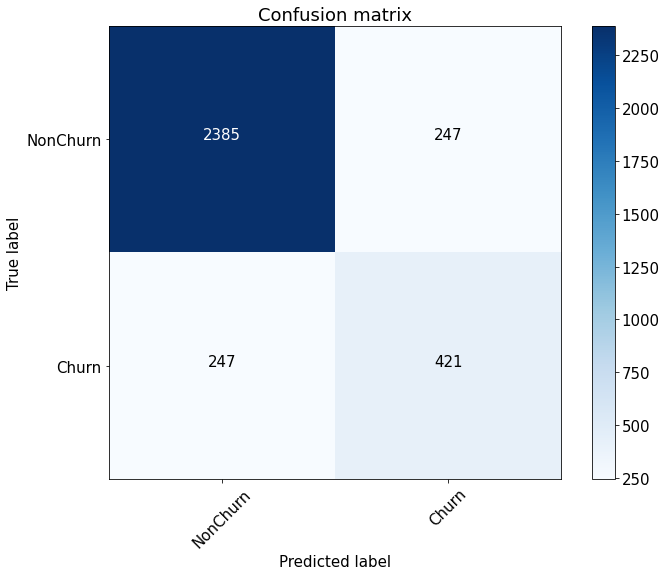

In [20]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.show()

CatBoostClassifier:\
Best Threshold=0.330330, F-Score=0.631, Precision=0.631, Recall=0.632

LGBMClassifier:\
Best Threshold=0.339072, F-Score=0.612, Precision=0.608, Recall=0.615

#### Для выбранной модели CatBoost

In [21]:
TN = cnf_matrix[0][0]
FP = cnf_matrix[0][1]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]

In [22]:
retain = (FP + TP) * 1
income = TP * 2

In [23]:
gain = income - retain
gain

174

Поскольку с каждого правильно классифицированного (True Positive) дают 2 доллора против 1, то в этом случае стоит обратить внимание на DS Precision.